<a href="https://colab.research.google.com/github/Udhay707/Pytorch-GAN/blob/main/Training_NN_With_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [153]:
dataset = MNIST(root='data/',
                download=True,
                transform=ToTensor())

In [154]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [155]:
batch_size=128

In [156]:
train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(dataset, batch_size*2, num_workers=4, pin_memory=True)

Image shape: torch.Size([128, 1, 28, 28])


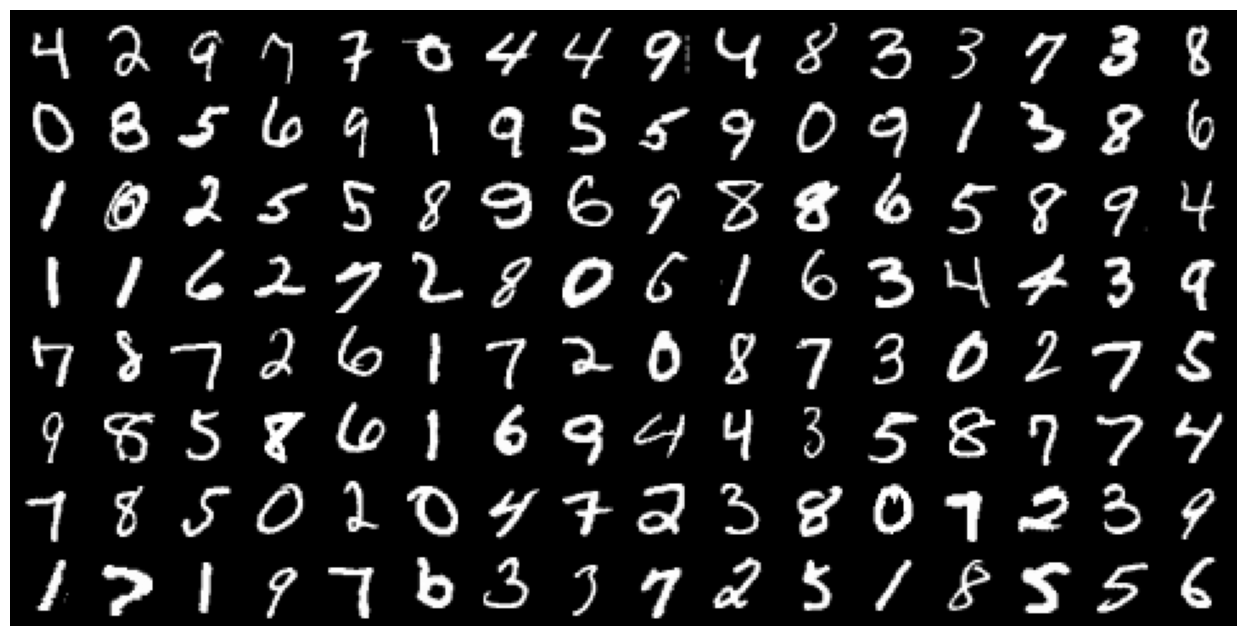

In [157]:
for images, labels in  train_loader:
  print(f'Image shape: {images.shape}')
  plt.figure(figsize = (16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0)) #permute will rearrage the matrix from 1x28x28 to 28x28x1 and make grid will arrange many images in a single grid
  break

Hidden Layers - computed manually

In [158]:
for images,labels in train_loader:
    print(f'Image shape: {images.shape}')
    inputs = images.reshape(-1, 784) #flatten
    print(f'Image shape: {inputs.shape}')
    break

Image shape: torch.Size([128, 1, 28, 28])
Image shape: torch.Size([128, 784])


In [159]:
input_size = inputs.shape[-1]
hidden_size = 64

In [160]:
layer1 = nn.Linear(input_size, hidden_size)
layer1_outputs = layer1(inputs)
layer1_outputs.shape, layer1_outputs

(torch.Size([128, 64]),
 tensor([[ 0.1552, -0.0272,  0.2817,  ...,  0.4126, -0.0299, -0.3505],
         [ 0.3874, -0.1438,  0.0831,  ...,  0.2322, -0.0714, -0.2119],
         [ 0.1107,  0.0236, -0.0418,  ...,  0.0069,  0.0568, -0.1660],
         ...,
         [ 0.4826,  0.0552,  0.1459,  ...,  0.2286,  0.2410, -0.5032],
         [ 0.1567,  0.0628,  0.2677,  ...,  0.1219,  0.1080, -0.2751],
         [ 0.1745,  0.0437,  0.1137,  ...,  0.0510, -0.0567, -0.0191]],
        grad_fn=<AddmmBackward0>))

Relu Example

In [161]:
F.relu(torch.Tensor([[1,2], [0, -1]]))

tensor([[1., 2.],
        [0., 0.]])

computing relu for all layer1 output

In [162]:
relu_outputs = F.relu(layer1_outputs)
torch.min(relu_outputs), torch.min(layer1_outputs)

(tensor(0., grad_fn=<MinBackward1>), tensor(-0.6916, grad_fn=<MinBackward1>))

Creating the output layer

In [163]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)
layer2_output = layer2(relu_outputs)
layer2_output.shape, layer2_output

(torch.Size([128, 10]),
 tensor([[-0.1151, -0.2036,  0.0704,  ...,  0.1710,  0.2219,  0.0112],
         [-0.0303, -0.2073,  0.1542,  ...,  0.1303,  0.1528, -0.1098],
         [ 0.0546, -0.1139,  0.1157,  ...,  0.0960,  0.0014, -0.0343],
         ...,
         [-0.0458, -0.2029,  0.1157,  ...,  0.1115,  0.1300, -0.0018],
         [-0.0404, -0.1962,  0.1784,  ...,  0.2080,  0.2471, -0.1053],
         [-0.0020, -0.2071,  0.2004,  ...,  0.1671,  0.1005, -0.0971]],
        grad_fn=<AddmmBackward0>))

Computing Loss

In [164]:
F.cross_entropy(layer2_output, labels) #cross entrophy applies softmax

tensor(2.3030, grad_fn=<NllLossBackward0>)

In [165]:
class MnistModel(nn.Module):
    def __init__(self, input_size, number_of_hidden_layer, output_size, *hidden_layer_sizes):
        super().__init__()
        self.device = get_gpu_if_available()  # Track the device
        self.hidden = []

        if len(hidden_layer_sizes) != number_of_hidden_layer:
            raise Exception(f"Number of hidden layers are {number_of_hidden_layer}, but specified {len(hidden_layer_sizes)} hidden layer sizes")

        self.linear1 = nn.Linear(input_size, hidden_layer_sizes[0])

        for index in range(len(hidden_layer_sizes)):
            if index + 1 == len(hidden_layer_sizes):
                self.hidden.append(nn.Linear(hidden_layer_sizes[index], output_size))
            else:
                self.hidden.append(nn.Linear(hidden_layer_sizes[index], hidden_layer_sizes[index + 1]))

    def forward(self, xb):
        xb = xb.to(self.device)  # Ensure input is on the same device as the model
        xb = xb.reshape(xb.size(0), -1)  # Flatten the input
        output = self.linear1(xb)
        output = F.relu(output)
        for k in self.hidden:
            output = k(output)
            output = F.relu(output)  # Apply ReLU after each hidden layer
        return output

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)  # Ensure images and labels are on the same device as the model
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)  # Ensure images and labels are on the same device as the model
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_validation_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_validation_losses).mean()
        batch_validation_Accuracy =  [x['val_acc'] for x in outputs]
        epoch_accuracy = torch.stack(batch_validation_Accuracy).mean()
        return {'epoch_loss': epoch_loss, 'epoch_accuracy': epoch_accuracy}

    def epoch_end(self, epoch, result):  # Print epoch results
        print(f"Epoch {epoch}: val_loss = {result['epoch_loss']:.4f}, val_acc = {result['epoch_accuracy']:.4f}")


In [166]:
def accuracy(prediction, labels):
  _, preds = torch.max(prediction, dim=1)
  return torch.sum(preds == labels).item() / len(preds)

Create a neural network with 2 hidden layers

In [167]:
input_size = 28*28
output_size = 10
number_of_hidden_layers = 2
hidden1 = 150
hidden2 = 32

In [168]:
model = MnistModel(input_size, number_of_hidden_layers, output_size, hidden1, hidden2)

In [169]:
def get_gpu_if_available():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data):
  device = get_gpu_if_available()
  if isinstance(data, (list, tuple)):
    return [to_device(x) for x in data]
  return data.to(device, non_blocking = True)

Moving data to device

In [170]:
for images, labels in train_loader:
  print(images.shape)
  print(images.device)
  images = to_device(images)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cpu
cuda:0


Class to load the batch to device

In [171]:
# Class to load the batch to device
class DeviceDataLoader():
    def __init__(self, dataLoader, device):
        self.dataLoader = dataLoader
        self.device = device

    def __iter__(self):
        for images, labels in self.dataLoader:
            images, labels = images.to(self.device, non_blocking=True), labels.to(self.device, non_blocking=True)
            yield images, labels

    def __len__(self):
        return len(self.dataLoader)


In [172]:
device = get_gpu_if_available()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [173]:
def evaluate(model, dataloader):
    model = model.to(device)
    outputs = [model.validation_step(batch) for batch in dataloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, validation_loader, optimizer=torch.optim.Adam):
    history = []
    optimizer = optimizer(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()  # Set model to evaluation mode after training
        result = evaluate(model, validation_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history



In [174]:
device = get_gpu_if_available()
model = MnistModel(input_size, number_of_hidden_layers, output_size, hidden1, hidden2)
model = model.to(device)  # Move the model to the correct device (CPU or GPU)

In [175]:
model.parameters()

<generator object Module.parameters at 0x797d9f6e1e70>

In [176]:
for i in model.parameters():
  print(i)
  break

Parameter containing:
tensor([[ 0.0034,  0.0235,  0.0004,  ..., -0.0211, -0.0283, -0.0349],
        [ 0.0191, -0.0092, -0.0085,  ..., -0.0333, -0.0109,  0.0226],
        [-0.0164, -0.0167,  0.0063,  ...,  0.0045,  0.0105, -0.0179],
        ...,
        [ 0.0195,  0.0028,  0.0011,  ...,  0.0343,  0.0061,  0.0157],
        [-0.0240, -0.0310, -0.0114,  ...,  0.0283,  0.0314,  0.0338],
        [ 0.0308,  0.0068,  0.0141,  ..., -0.0229, -0.0014,  0.0182]],
       device='cuda:0', requires_grad=True)


In [177]:
# Get the available device (GPU or CPU)
device = get_gpu_if_available()

# Create the model and move it to the device
model = MnistModel(input_size, number_of_hidden_layers, output_size, hidden1, hidden2)
model = model.to(device)

# Wrap the DataLoader to move data to device during iteration
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

# Evaluate the model
history = evaluate(model, val_loader)
print(history)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

Now lets train the model

In [ ]:
history = fit(5, 1e-2, model, train_loader, val_loader, torch.optim.Adam)

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');